### 23~24년도 총결산 장르별 시각화

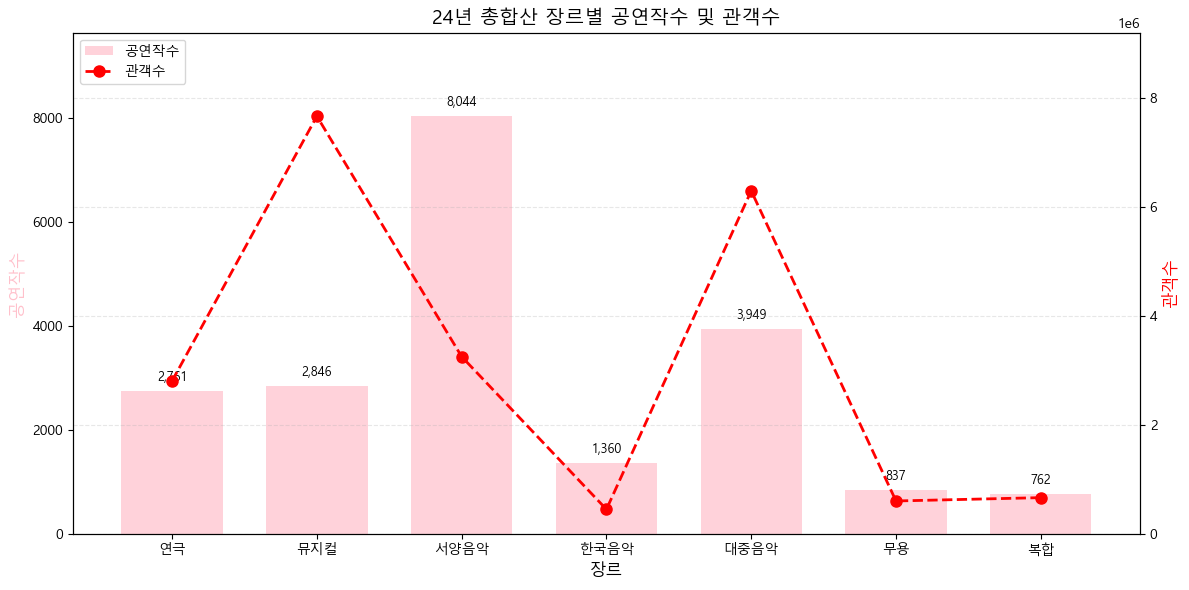

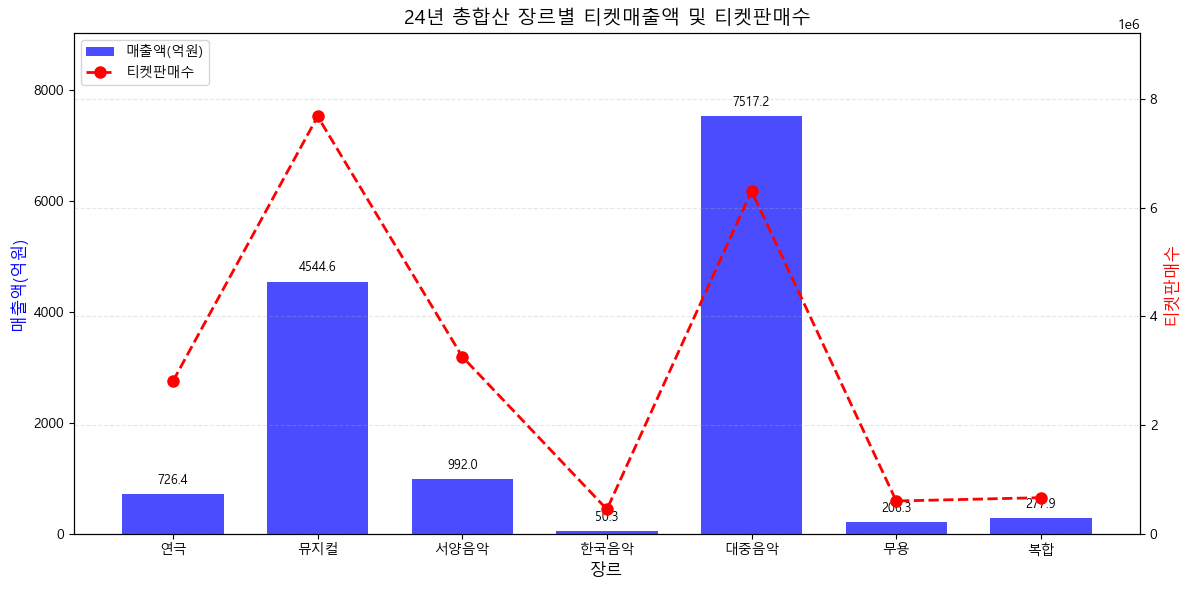

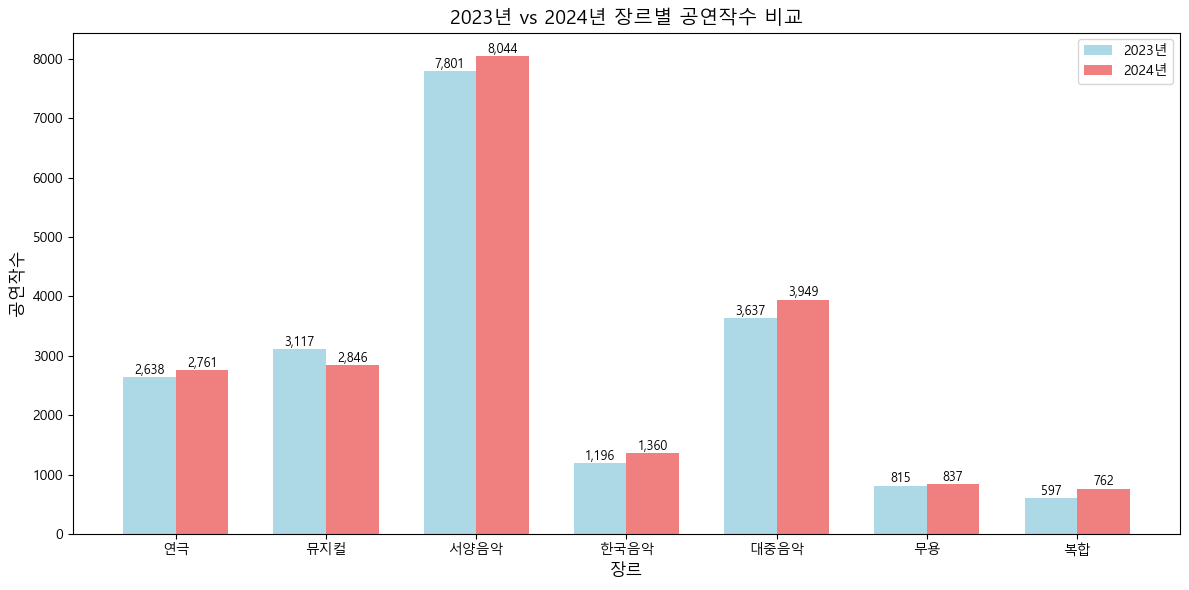

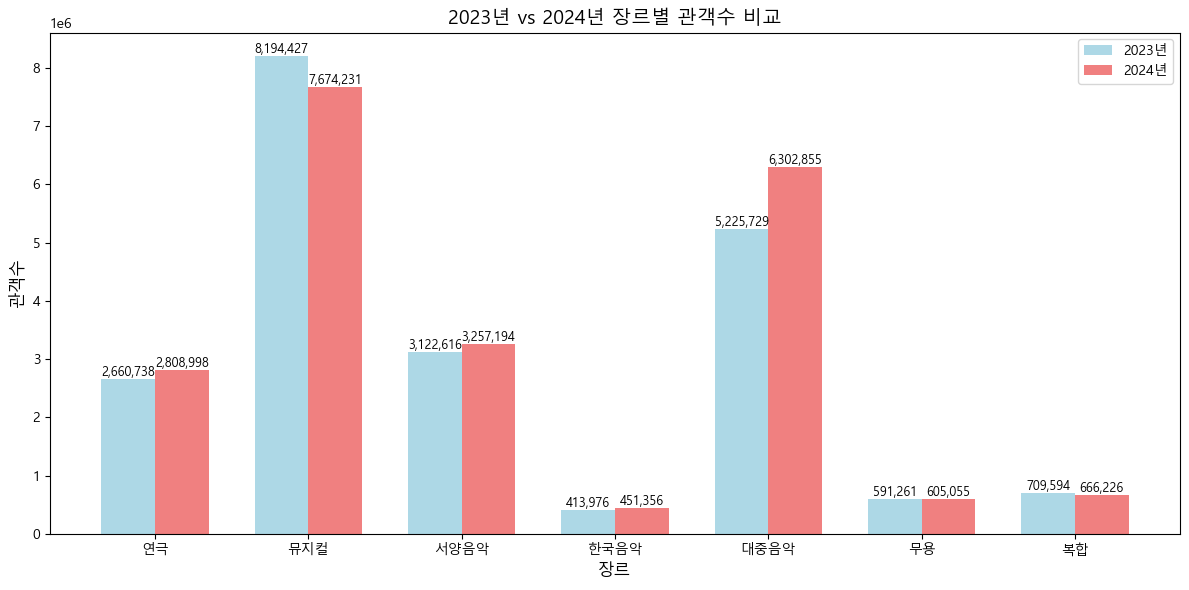

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 맑은 고딕 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 시스템에서 맑은 고딕 사용
plt.rcParams['axes.unicode_minus'] = False      # 마이너스 기호 표시 문제 해결

# CSV 파일 불러오기 (인코딩 지정)
try:
    df = pd.read_csv('kopis-data-collector-main/data_date_range/장르별 통계_20230101~20241231.csv', encoding='utf-8')
except UnicodeDecodeError:
    # UTF-8로 안되면 다른 인코딩 시도
    df = pd.read_csv('kopis-data-collector-main/data_date_range/장르별 통계_20230101~20241231.csv', encoding='cp949')



# 여기서 실제 열 이름 확인 후 아래 매핑을 수정
column_mapping = {
    '장르': 'genre',  # 실제 열 이름으로 수정 필요
    '개막편수': 'opening_count',
    '상연횟수': 'performance_count',
    '매출액': 'sales',
    '매출액점유율': 'sales_share',
    '관객수': 'audience',
    '관객점유율': 'audience_share'
}

# 열 이름이 정확히 매핑되었는지 확인
if '장르' in df.columns:
    df = df.rename(columns=column_mapping)
else:
    # 'genre'라는 열이 이미 있거나 다른 이름일 경우
    print("'장르' 열을 찾을 수 없습니다. 현재 열 이름:", df.columns.tolist())
    # 열 이름에 공백이나 특수문자가 있을 수 있음
    # 또는 이미 영문 이름일 수도 있음

df = df.rename(columns=column_mapping)

# 데이터에 연도 추가 (9개 장르가 24개씩, 처음 12개는 2023년, 뒤 12개는 2024년)
# 각 연도는 9개의 장르로 구성됨
num_genres = 9
num_months_per_year = 12
rows_per_month = num_genres

# 연도와 월 할당
df['year'] = 0
df['month'] = 0

for i in range(len(df)):
    month_block = i // rows_per_month
    if month_block < num_months_per_year:
        df.loc[i, 'year'] = 2023
        df.loc[i, 'month'] = month_block + 1
    else:
        df.loc[i, 'year'] = 2024
        df.loc[i, 'month'] = month_block - num_months_per_year + 1

# 장르 매핑 정의
genre_mapping = {
    '연극': '연극',
    '뮤지컬': '뮤지컬',
    '서양음악(클래식)': '서양음악',
    '한국음악(국악)': '한국음악',
    '대중음악': '대중음악',
    '무용(서양/한국무용)': '무용',
    '대중무용': '대중무용',
    '서커스/마술': '복합',
    '복합': '기타'
}

df['genre_group'] = df['genre'].map(lambda x: genre_mapping.get(x, x))

# 연도별, 장르별로 데이터 집계
yearly_genre_stats = df.groupby(['year', 'genre_group']).agg({
    'opening_count': 'sum',
    'performance_count': 'sum',
    'sales': 'sum',
    'audience': 'sum'
}).reset_index()

# 주요 장르만 선택 (그래프에 표시된 것과 동일하게)
selected_genres = ['연극', '뮤지컬', '서양음악', '한국음악', '대중음악', '무용', '복합']
plot_df = yearly_genre_stats[yearly_genre_stats['genre_group'].isin(selected_genres)]

# 2024년 데이터만 선택 (최종 그래프용)
df_2024 = plot_df[plot_df['year'] == 2024]

# 장르 순서를 유지하기 위한 데이터프레임 생성
# 선택된 순서대로 데이터 정렬하기
ordered_data = []
for genre in selected_genres:
    genre_data = df_2024[df_2024['genre_group'] == genre]
    if not genre_data.empty:
        ordered_data.append(genre_data)

ordered_df = pd.concat(ordered_data, ignore_index=True)

# 첫 번째 그래프: 장르별 공연작수와 관객수
fig, ax1 = plt.subplots(figsize=(12, 6))

# 바 그래프: 공연작수
bars = ax1.bar(ordered_df['genre_group'], ordered_df['opening_count'], width=0.7, color='pink', alpha=0.7, label='공연작수')

# 두 번째 y축 설정
ax2 = ax1.twinx()

# 라인 그래프: 관객수
line = ax2.plot(ordered_df['genre_group'], ordered_df['audience'], 'r--', marker='o', linewidth=2, markersize=8, label='관객수')

# x축, y축 라벨 설정
ax1.set_xlabel('장르', fontsize=12)
ax1.set_ylabel('공연작수', color='pink', fontsize=12)
ax2.set_ylabel('관객수', color='r', fontsize=12)

# 축 범위 설정 - 데이터에 맞게 자동 설정 (여백 추가)
y1_max = ordered_df['opening_count'].max() * 1.2
y2_max = ordered_df['audience'].max() * 1.2
ax1.set_ylim(0, y1_max)
ax2.set_ylim(0, y2_max)

# 범례 설정
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=10)

# 제목 설정
plt.title('24년 총합산 장르별 공연작수 및 관객수', fontsize=14)

# 그리드 설정 - 배경에만 희미하게
ax1.grid(False)
ax2.grid(True, axis='y', alpha=0.3, linestyle='--')

# 막대 위에 값 표시
for i, v in enumerate(ordered_df['opening_count']):
    ax1.text(i, v + (y1_max * 0.02), f'{v:,}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# 두 번째 그래프: 장르별 티켓매출액과 티켓판매매수
fig, ax1 = plt.subplots(figsize=(12, 6))

# 바 그래프: 티켓매출액 (단위: 억원)
bars = ax1.bar(ordered_df['genre_group'], ordered_df['sales'] / 100000000, width=0.7, color='blue', alpha=0.7, label='매출액(억원)')

# 두 번째 y축 설정
ax2 = ax1.twinx()

# 라인 그래프: 티켓판매매수
line = ax2.plot(ordered_df['genre_group'], ordered_df['audience'], 'r--', marker='o', linewidth=2, markersize=8, label='티켓판매수')

# x축, y축 라벨 설정
ax1.set_xlabel('장르', fontsize=12)
ax1.set_ylabel('매출액(억원)', color='blue', fontsize=12)
ax2.set_ylabel('티켓판매수', color='r', fontsize=12)

# 축 범위 설정 - 데이터에 맞게 자동 설정 (여백 추가)
y1_max = (ordered_df['sales'].max() / 100000000) * 1.2
y2_max = ordered_df['audience'].max() * 1.2
ax1.set_ylim(0, y1_max)
ax2.set_ylim(0, y2_max)

# 범례 설정
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=10)

# 제목 설정
plt.title('24년 총합산 장르별 티켓매출액 및 티켓판매수', fontsize=14)

# 그리드 설정
ax1.grid(False)
ax2.grid(True, axis='y', alpha=0.3, linestyle='--')

# 막대 위에 값 표시
for i, v in enumerate(ordered_df['sales'] / 100000000):
    ax1.text(i, v + (y1_max * 0.02), f'{v:.1f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# 연도별 비교 그래프 (2023년 vs 2024년 장르별 공연작수)
fig, ax = plt.subplots(figsize=(12, 6))

# 장르 순서대로 피벗 데이터 생성
pivot_data = []
for genre in selected_genres:
    genre_data = yearly_genre_stats[yearly_genre_stats['genre_group'] == genre]
    if not genre_data.empty:
        pivot_data.append(genre_data)

ordered_yearly_stats = pd.concat(pivot_data, ignore_index=True)
pivot_df = ordered_yearly_stats.pivot_table(index='genre_group', columns='year', values='opening_count', aggfunc='sum')
pivot_df = pivot_df.reindex(selected_genres)

# 연도별로 바 그래프 그리기
x = np.arange(len(pivot_df.index))
width = 0.35

ax.bar(x - width/2, pivot_df[2023], width, label='2023년', color='lightblue')
ax.bar(x + width/2, pivot_df[2024], width, label='2024년', color='lightcoral')

# 축 설정
ax.set_xlabel('장르', fontsize=12)
ax.set_ylabel('공연작수', fontsize=12)
ax.set_title('2023년 vs 2024년 장르별 공연작수 비교', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(pivot_df.index)
ax.legend()

# 막대 위에 값 표시
for i, v in enumerate(pivot_df[2023]):
    ax.text(i - width/2, v + 5, f'{v:,}', ha='center', va='bottom', fontsize=9)
    
for i, v in enumerate(pivot_df[2024]):
    ax.text(i + width/2, v + 5, f'{v:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 연도별 비교 그래프 (2023년 vs 2024년 장르별 관객수)
fig, ax = plt.subplots(figsize=(12, 6))

# 피벗 데이터 생성
pivot_df = ordered_yearly_stats.pivot_table(index='genre_group', columns='year', values='audience', aggfunc='sum')
pivot_df = pivot_df.reindex(selected_genres)

# 연도별로 바 그래프 그리기
ax.bar(x - width/2, pivot_df[2023], width, label='2023년', color='lightblue')
ax.bar(x + width/2, pivot_df[2024], width, label='2024년', color='lightcoral')

# 축 설정
ax.set_xlabel('장르', fontsize=12)
ax.set_ylabel('관객수', fontsize=12)
ax.set_title('2023년 vs 2024년 장르별 관객수 비교', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(pivot_df.index)
ax.legend()

# 막대 위에 값 표시
for i, v in enumerate(pivot_df[2023]):
    ax.text(i - width/2, v + 100, f'{v:,}', ha='center', va='bottom', fontsize=9)
    
for i, v in enumerate(pivot_df[2024]):
    ax.text(i + width/2, v + 100, f'{v:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 지역별 통계 분석

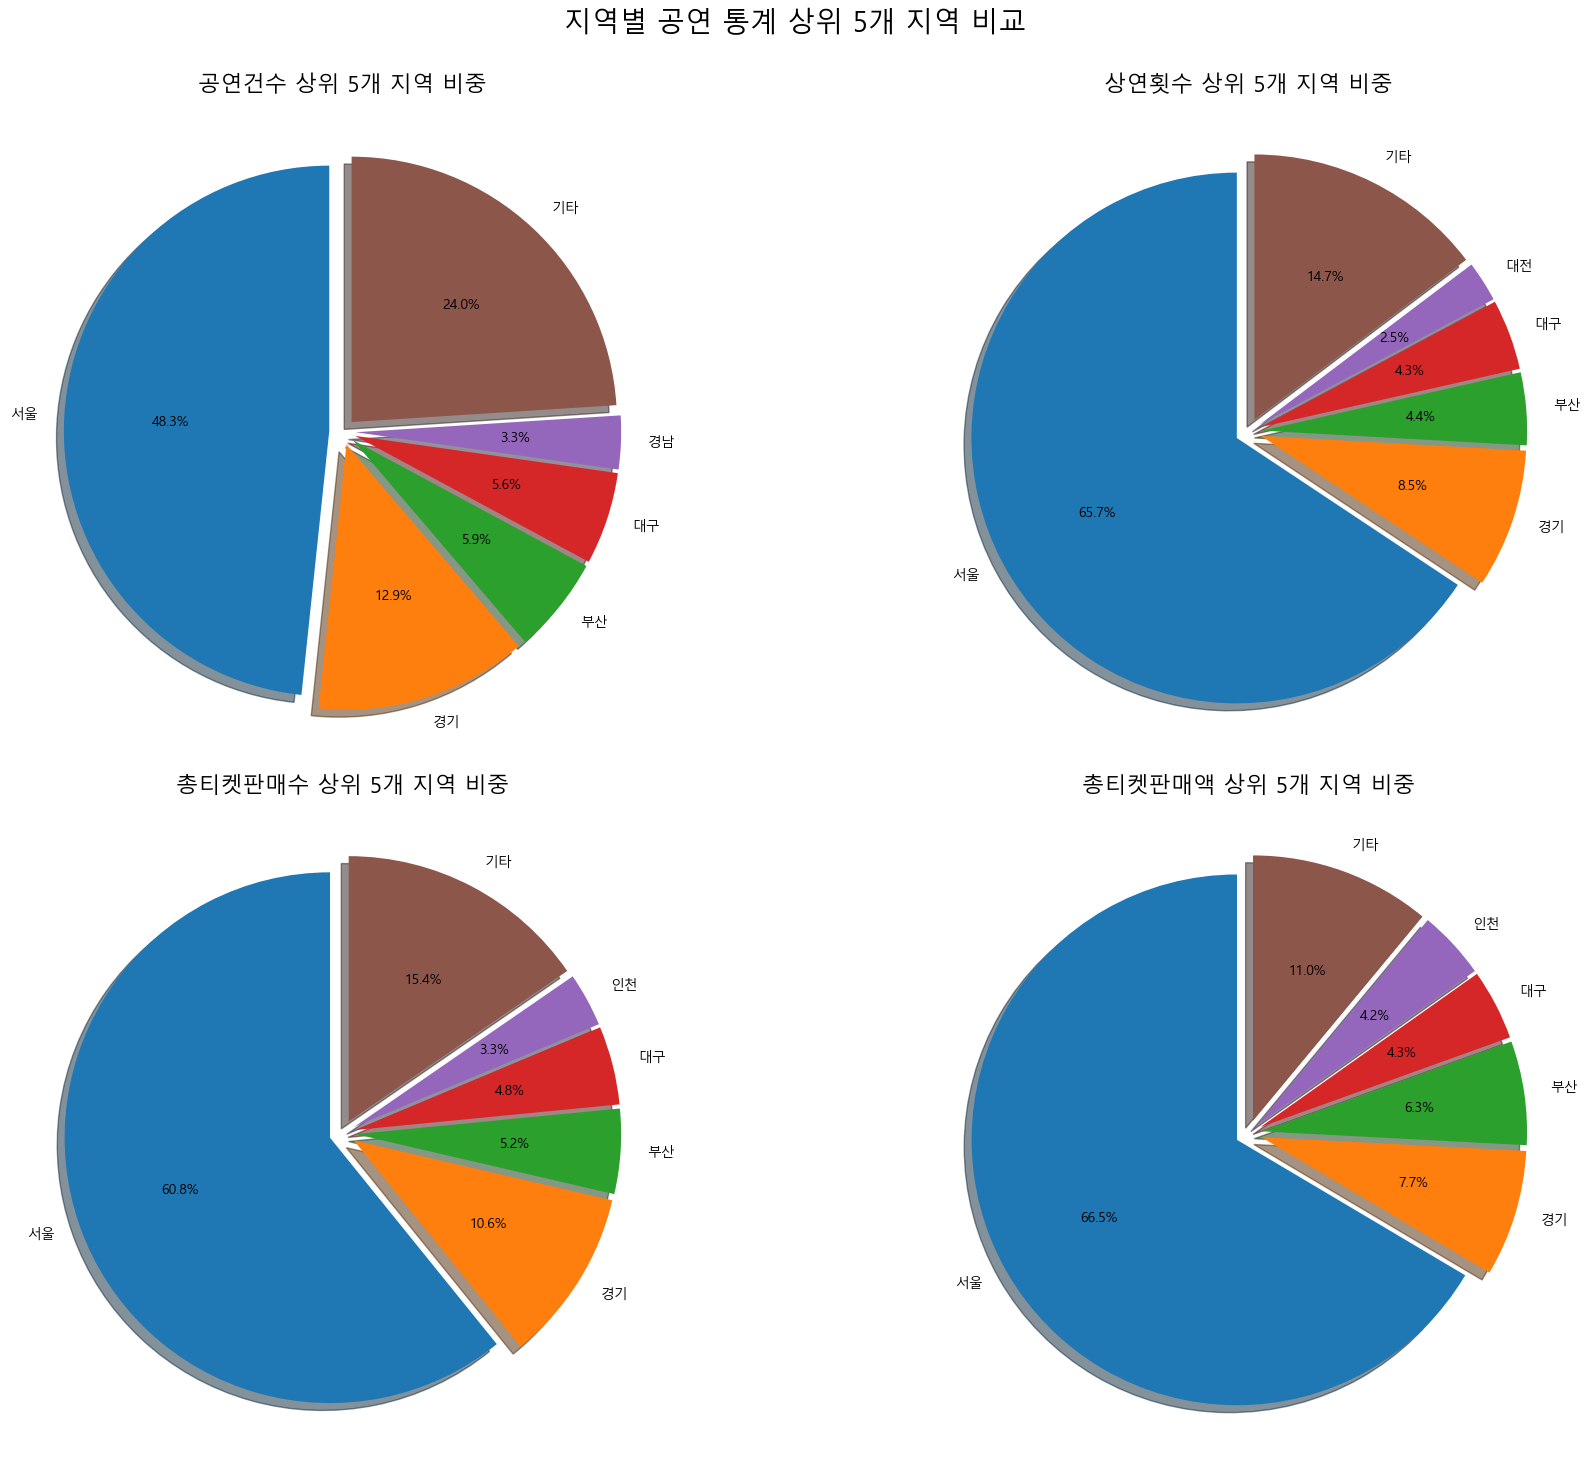

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# CSV 파일 읽기
df = pd.read_csv("kopis-data-collector-main/data_date_range/지역별 통계_20230101~20241231.csv")

# 지역별 데이터 집계
# '합계' 행을 제외하고 지역별로 집계
regions = ['서울', '경기', '인천', '부산', '대구', '울산', '경남', '경북', 
           '전북', '전남', '광주', '대전', '충북', '충남', '세종', '강원도', '제주도']

# 지역명에서 특정 지역만 필터링하여 집계
region_stats = df[df['지역명'].isin(regions)].groupby('지역명').agg({
    '공연건수': 'sum',
    '상연횟수': 'sum',
    '총티켓판매수': 'sum',
    '총티켓판매액': 'sum'
}).reset_index()


# 상위 5개 지역 파이 차트로 비교
plt.figure(figsize=(20, 15))

# 1. 공연건수 파이차트
plt.subplot(2, 2, 1)
top5_perf = region_stats.nlargest(5, '공연건수')
others = pd.DataFrame({
    '지역명': ['기타'],
    '공연건수': [region_stats['공연건수'].sum() - top5_perf['공연건수'].sum()]
})
pie_data = pd.concat([top5_perf, others])

plt.pie(pie_data['공연건수'], labels=pie_data['지역명'], autopct='%1.1f%%', 
        startangle=90, shadow=True, explode=[0.05]*6)
plt.title('공연건수 상위 5개 지역 비중', fontsize=16)

# 2. 상연횟수 파이차트
plt.subplot(2, 2, 2)
top5_shows = region_stats.nlargest(5, '상연횟수')
others = pd.DataFrame({
    '지역명': ['기타'],
    '상연횟수': [region_stats['상연횟수'].sum() - top5_shows['상연횟수'].sum()]
})
pie_data = pd.concat([top5_shows, others])

plt.pie(pie_data['상연횟수'], labels=pie_data['지역명'], autopct='%1.1f%%', 
        startangle=90, shadow=True, explode=[0.05]*6)
plt.title('상연횟수 상위 5개 지역 비중', fontsize=16)

# 3. 총티켓판매수 파이차트
plt.subplot(2, 2, 3)
top5_tickets = region_stats.nlargest(5, '총티켓판매수')
others = pd.DataFrame({
    '지역명': ['기타'],
    '총티켓판매수': [region_stats['총티켓판매수'].sum() - top5_tickets['총티켓판매수'].sum()]
})
pie_data = pd.concat([top5_tickets, others])

plt.pie(pie_data['총티켓판매수'], labels=pie_data['지역명'], autopct='%1.1f%%', 
        startangle=90, shadow=True, explode=[0.05]*6)
plt.title('총티켓판매수 상위 5개 지역 비중', fontsize=16)

# 4. 총티켓판매액 파이차트
plt.subplot(2, 2, 4)
top5_sales = region_stats.nlargest(5, '총티켓판매액')
others = pd.DataFrame({
    '지역명': ['기타'],
    '총티켓판매액': [region_stats['총티켓판매액'].sum() - top5_sales['총티켓판매액'].sum()]
})
pie_data = pd.concat([top5_sales, others])

plt.pie(pie_data['총티켓판매액'], labels=pie_data['지역명'], autopct='%1.1f%%', 
        startangle=90, shadow=True, explode=[0.05]*6)
plt.title('총티켓판매액 상위 5개 지역 비중', fontsize=16)

plt.tight_layout()
plt.suptitle('지역별 공연 통계 상위 5개 지역 비교', fontsize=20, y=0.98)
plt.subplots_adjust(top=0.92)
plt.show()


# 월별 추이 분석
# 날짜 데이터를 가공해야 함
# 이 분석은 데이터의 월별 구분이 명확할 경우에만 가능

### 규모별 통계 분석(2024년)

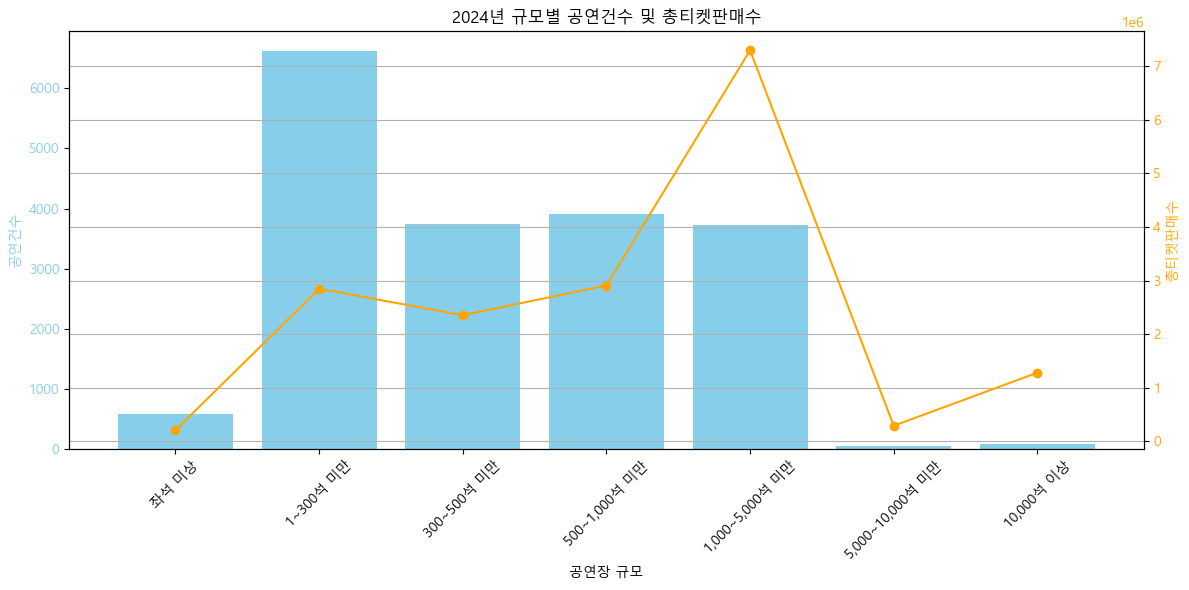

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import re

# 한글 폰트 설정 (Windows: 'Malgun Gothic', macOS: 'AppleGothic', Linux: 나눔폰트 등)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 사용자용
# plt.rcParams['font.family'] = 'AppleGothic'  # macOS 사용자용
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# CSV 파일 불러오기
file_path = 'kopis-data-collector-main/data_date_range/공연시설_연도_규모_분류.csv'  # Jupyter Notebook과 같은 폴더에 있어야 합니다
df = pd.read_csv(file_path)

# 2024년 데이터 필터링
df_2024 = df[df['연도'] == 2024]

# 규모별 공연건수 및 총티켓판매수 합계 집계
grouped = df_2024.groupby('규모').agg({
    '공연건수': 'sum',
    '총티켓판매수': 'sum'
}).reset_index()

# 정렬 키 추출 함수 (최소 좌석 수 기준)
def extract_min_seat(capacity_range):
    match = re.search(r'(\d+,?\d*)', capacity_range)
    if match:
        return int(match.group(1).replace(',', ''))
    return 0

grouped['정렬키'] = grouped['규모'].apply(extract_min_seat)
grouped = grouped.sort_values('정렬키')

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(12, 6))

# 바 차트: 공연건수
ax1.bar(grouped['규모'], grouped['공연건수'], color='skyblue', label='공연건수')
ax1.set_xlabel('공연장 규모')
ax1.set_ylabel('공연건수', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
plt.xticks(rotation=45)

# 라인 차트: 총티켓판매수
ax2 = ax1.twinx()
ax2.plot(grouped['규모'], grouped['총티켓판매수'], color='orange', marker='o', label='총티켓판매수')
ax2.set_ylabel('총티켓판매수', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('2024년 규모별 공연건수 및 총티켓판매수')
plt.tight_layout()
plt.grid(True)
plt.show()


### 규모별 통계 분석(2023년)

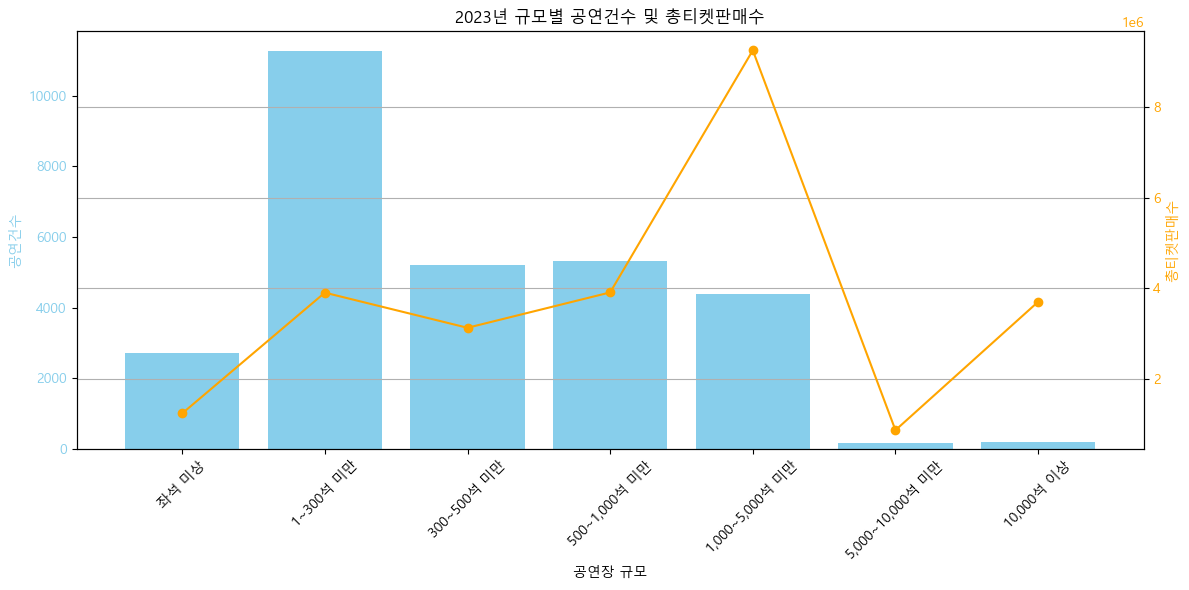

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import re

# 한글 폰트 설정 (Windows: 'Malgun Gothic', macOS: 'AppleGothic', Linux: 나눔폰트 등)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 사용자용
# plt.rcParams['font.family'] = 'AppleGothic'  # macOS 사용자용
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# CSV 파일 불러오기
file_path = 'kopis-data-collector-main/data_date_range/공연시설_연도_규모_분류.csv'  # Jupyter Notebook과 같은 폴더에 있어야 합니다
df = pd.read_csv(file_path)

# 2024년 데이터 필터링
df_2024 = df[df['연도'] == 2023]

# 규모별 공연건수 및 총티켓판매수 합계 집계
grouped = df_2024.groupby('규모').agg({
    '공연건수': 'sum',
    '총티켓판매수': 'sum'
}).reset_index()

# 정렬 키 추출 함수 (최소 좌석 수 기준)
def extract_min_seat(capacity_range):
    match = re.search(r'(\d+,?\d*)', capacity_range)
    if match:
        return int(match.group(1).replace(',', ''))
    return 0

grouped['정렬키'] = grouped['규모'].apply(extract_min_seat)
grouped = grouped.sort_values('정렬키')

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(12, 6))

# 바 차트: 공연건수
ax1.bar(grouped['규모'], grouped['공연건수'], color='skyblue', label='공연건수')
ax1.set_xlabel('공연장 규모')
ax1.set_ylabel('공연건수', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
plt.xticks(rotation=45)

# 라인 차트: 총티켓판매수
ax2 = ax1.twinx()
ax2.plot(grouped['규모'], grouped['총티켓판매수'], color='orange', marker='o', label='총티켓판매수')
ax2.set_ylabel('총티켓판매수', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('2023년 규모별 공연건수 및 총티켓판매수')
plt.tight_layout()
plt.grid(True)
plt.show()
